<a href="https://colab.research.google.com/github/alvarogharo/machine-learning-sklearn/blob/master/wood-deformation-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 1: Reconocimiento de patrones



## Drive data import and visualization

In [0]:
import pandas as pd
            
with open('drive/My Drive/defectos_madera_entrenamiento.csv', 'r') as csvarchivo:
  df = pd.read_csv(csvarchivo,";")
  
df

In [0]:
import pandas as pd
            
with open('drive/My Drive/Universidad/Master/Patrones/Practica Defectos de madera/defectos_madera_entrenamiento.csv', 'r') as csvarchivo:
  df = pd.read_csv(csvarchivo,";")
  
df

## First preprocessing and feature/tag division

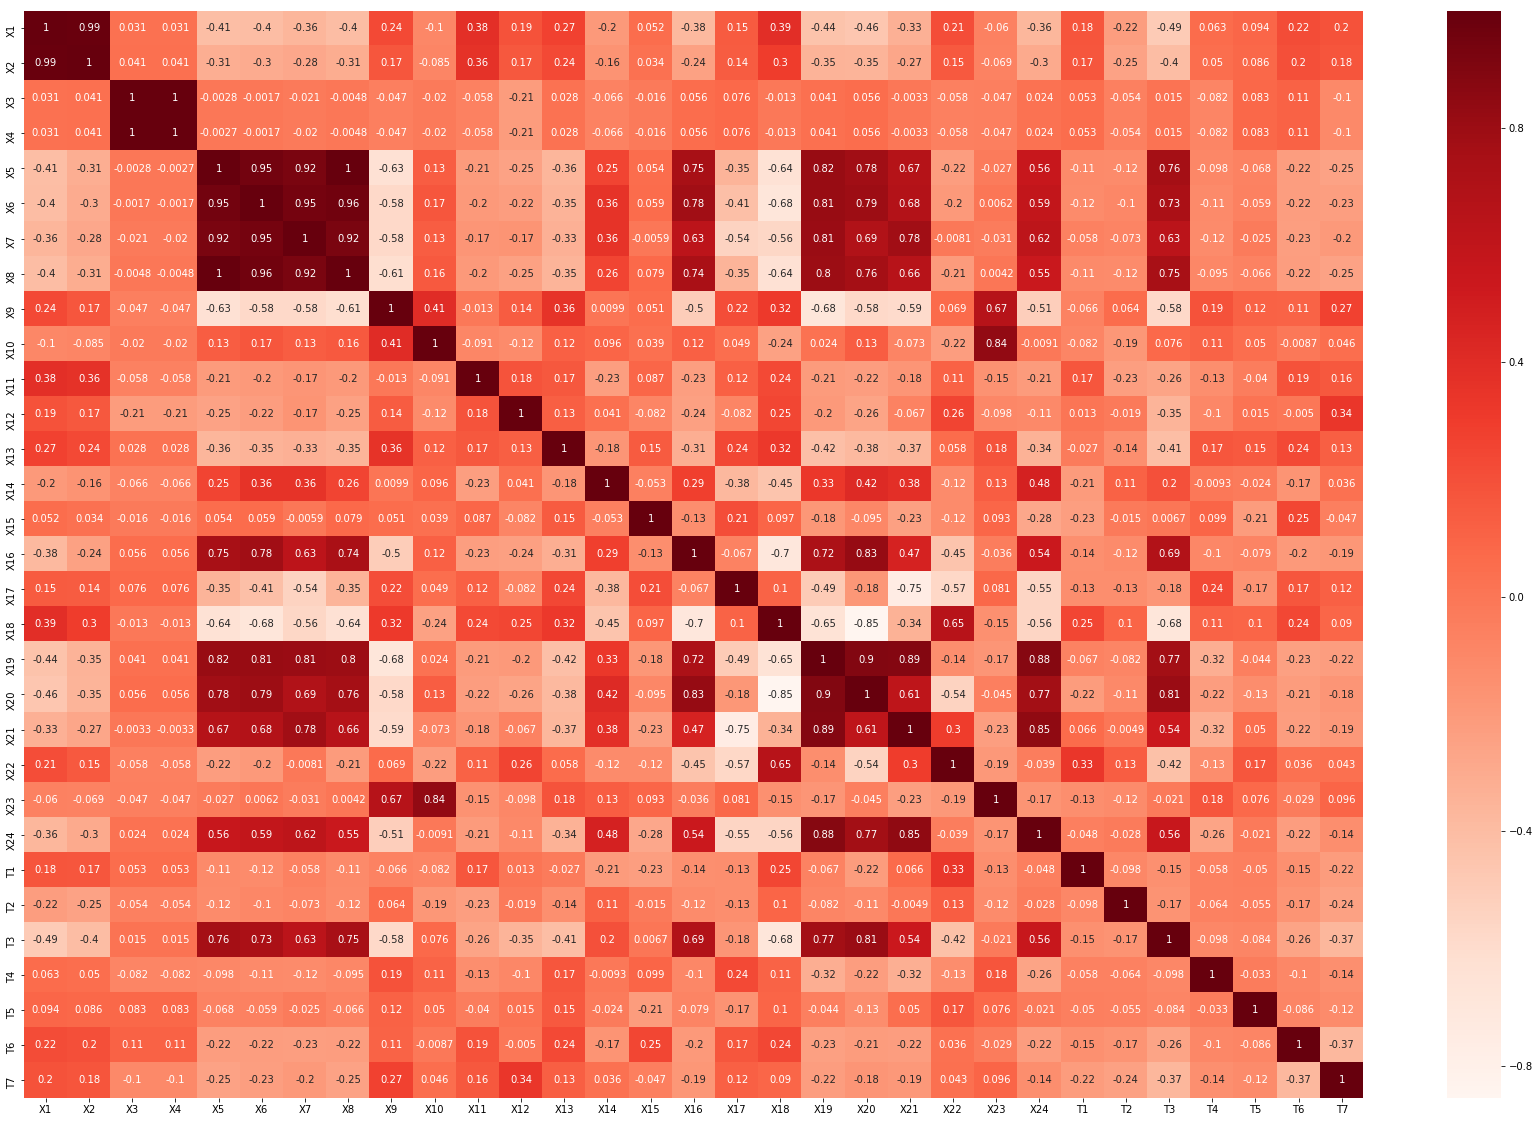

(1640, 21)
Counter({6: 571, 5: 340, 2: 331, 1: 160, 0: 133, 3: 60, 4: 45})


In [0]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,20))
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

#df['X25']= np.multiply(df['X1'][:].values, df['X3'][:].values)

# Row randomization
df = df.sample(frac=1)

# features/tag division
X = df[['X1', 'X3','X5','X6','X7','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24']][:]
y = df[['T1','T2','T3','T4','T5','T6','T7']][:]


print(X.values.shape)

#X = np.append(X.values,[X.values[:,0] * X.values[:,0]], axis=1)

# Onehot representation to integer
y_int = y.values
y_int = [np.where(r==1)[0][0] for r in y_int]

# Data balance visulization
print(collections.Counter(y_int))

## Balancing

In [0]:
from imblearn.over_sampling import SMOTE
from imblearn import under_sampling

# Not majority oversampling
smote = SMOTE('not majority')
allknn = under_sampling.NearMiss('majority')
X_os, y_os = allknn.fit_sample(X,y_int) 
X_os, y_os = smote.fit_sample(X_os,y_os) 

# Data balance results
print(collections.Counter(y_os))

#from sklearn.decomposition import PCA
#pca = PCA()
#pca.fit(X_os)
#print(pca.explained_variance_ratio_)


Counter({0: 340, 1: 340, 2: 340, 3: 340, 4: 340, 5: 340, 6: 340})


## Whitening

In [0]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

X = preprocessing.scale(X)
#scaler = StandardScaler()
#scaler.fit(X_os)
#X_os = scaler.transform(X_os)
X_os = preprocessing.scale(X_os)

## Auxiliar print functions

In [0]:
from sklearn.metrics import confusion_matrix

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

def fitandprint(clf, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=442)

  y_pred = clf.fit(X_train, y_train).predict(X_test)

  scores = cross_val_score(clf,X_train, y_train,cv=5)
  print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  print()
  clf.fit(X_train, y_train)
  scores = clf.score(X_test,y_test)
  print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  print()

  plot_confusion_matrix(y_test, y_pred, classes=['0', '1', '2', '3', '4', '5', '6'], normalize=True,
                        title='Normalized confusion matrix')

## Shared imports

In [0]:
from time import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

## Random forest classifier

RandomizedSearchCV took 6.94 seconds for 1 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.917 (std: 0.020)
Parameters: {'min_samples_split': 4, 'max_features': 4, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}

Normalized confusion matrix


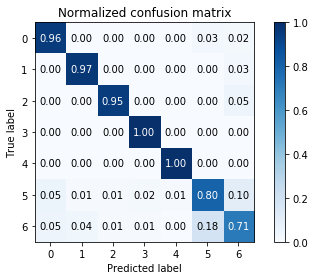

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Hyper-parameters for randomsearch
param_dist = {"max_depth": [None],
              "max_features":  [4],
              "min_samples_split":  [4],
              "bootstrap": [False],
              "criterion": ["gini"]}

clf = RandomForestClassifier(n_estimators=80)

# Randomized search
n_iter_search = 1
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time()
random_search.fit(X_os, y_os)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)


#scores = cross_val_score(forest,X,y,cv=5)
#print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.2, random_state=45462)

clf = RandomForestClassifier(n_estimators=50, max_depth=None, max_features=4, min_samples_split=4, bootstrap=False, criterion="gini")
y_pred = clf.fit(X_train,y_train).predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes=['0', '1', '2', '3', '4', '5', '6'], normalize=True,
                      title='Normalized confusion matrix')


In [0]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
scores = cross_val_score(clf,X_os, y_os,cv=5)
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.8560 (+/- 0.06)


## Kneigbours Classifier

Accuracy: 0.8959 (+/- 0.03)
Normalized confusion matrix


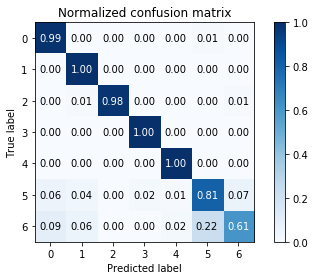

In [0]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.2, random_state=45462)

clf = KNeighborsClassifier(n_neighbors=1, algorithm="ball_tree", weights="distance", leaf_size=50, p=2)
y_pred = clf.fit(X_train,y_train).predict(X_test)

scores = cross_val_score(clf,X_os, y_os,cv=5)
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

plot_confusion_matrix(y_test, y_pred, classes=['0', '1', '2', '3', '4', '5', '6'], normalize=True,
                      title='Normalized confusion matrix')

## Stochastick Gradient Descent

In [0]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=3000000)
scores = cross_val_score(clf,X_os, y_os,cv=5)
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.7969 (+/- 0.05)


## Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
scores = cross_val_score(clf,X_os, y_os,cv=5)
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
from sklearn.naive_bayes import BernoulliNB 
clf = BernoulliNB()
scores = cross_val_score(clf,X_os, y_os,cv=5)
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.7784 (+/- 0.03)
Accuracy: 0.6893 (+/- 0.02)


## SVM classifier

### nuSVC

In [0]:
from sklearn import svm

# specify parameters and distributions to sample from
param_dist = {"gamma": np.arange(0.1,1,0.05),
             "nu": np.arange(0.1,1,0.05),
             "kernel": ["linear","rbf","poly"],
             "probability": [True, False],
             "decision_function_shape": ["ovo","ovr"]}
clf = svm.NuSVC(random_state = 5645)

# run randomized search
n_iter_search = 500
random_search = RandomizedSearchCV(clf, param_distributions = param_dist, n_iter = n_iter_search, n_jobs = 4, cv = 5, random_state = 2017)

start = time()
random_search.fit(X_os, y_os)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

### SVC



In [0]:
from sklearn import svm

# specify parameters and distributions to sample from
param_dist = {"gamma": np.arange(0.05,1,0.05),
             "C": np.arange(1,10,1),
             "kernel": ["rbf"],
             "probability": [True, False],
             "decision_function_shape": ["ovo","ovr"]}
clf = svm.SVC(probability = True, random_state = 5645)

# run randomized search
n_iter_search = 684
random_search = RandomizedSearchCV(clf, param_distributions = param_dist, n_iter = n_iter_search, n_jobs = 4, cv = 5, random_state = 2017)

start = time()
random_search.fit(X_os, y_os)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

Accuracy: 0.9406 (+/- 0.02)

Accuracy: 0.9580 (+/- 0.00)

Normalized confusion matrix


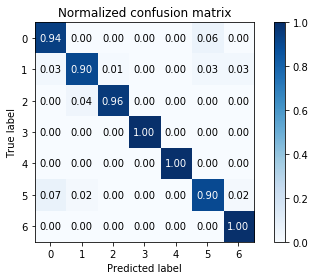

In [0]:
from sklearn import svm

clf = svm.SVC(decision_function_shape="ovo", gamma=0.3, C=5 ,probability = False, random_state = 564785)

fitandprint(clf, X_os, y_os)

#### SVC ensemble

In [0]:
from sklearn.ensemble import BaggingClassifier

clf = svm.SVC(decision_function_shape="ovo", gamma=0.3, C=5 ,probability = False, random_state = 564785)
bagg = BaggingClassifier(base_estimator=clf, n_estimators=30, random_state=314)

fitandprint(bagg, X_os, y_os)

## Voting SVM and RandomForest

In [0]:
from sklearn.ensemble import VotingClassifier

clf1 = svm.SVC(decision_function_shape="ovo", gamma=0.3, C=5 ,probability = False, random_state = 564785)
clf2 = RandomForestClassifier(n_estimators=80, min_samples_split=4, max_features=4, max_depth=None, criterion='gini', bootstrap=False)

eclf = VotingClassifier(estimators=[('sv', clf1), ('rf', clf2)], voting='hard')

fitandprint(eclf, X_os, y_os)